In [1]:
import seaborn as sns
import os 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
dir = os.getcwd()

TypeError: 'float' object cannot be interpreted as an integer

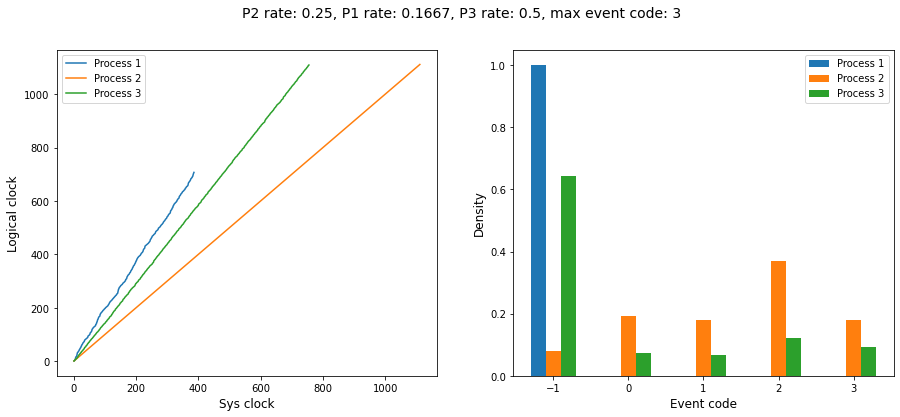

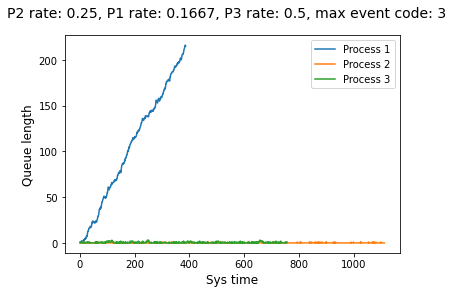

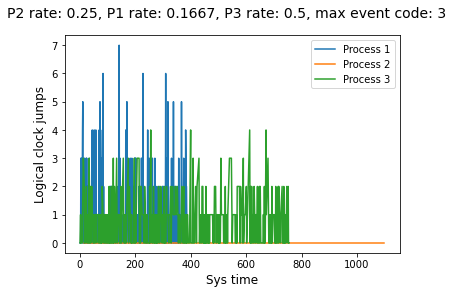

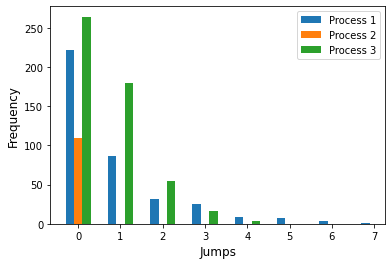

In [2]:
shifts = [-0.2, 0, 0.2]
for folder in os.listdir(dir):
    if folder.startswith('experiment_'):
        path = dir + '/' + folder 
        dfs = [] 
        colors = ['orange', 'blue', 'green']
        rand = folder.split('_')[-1]
        experiment = {'process': [], 'rate': [], 'rand': rand}
        for i, file in enumerate(os.listdir(path)): 
            filepath = f"{path}/{file}"
            with open(filepath, "r") as f: 
                f.seek(0)
                header = f.readline()
                f.seek(0)
            experiment['rate'].append(float(header.split()[-1]))
            experiment['process'].append(header.split()[3])
            
            df = pd.read_csv(filepath, sep=',', engine='python', skiprows=1,
                            names = ['event', 'sys_clock', 'logical_clock', 'code', 'queue_length', 'msg'])
            df['event'] = df['event'].str.replace('event: ','')
            df['sys_clock'] = df['sys_clock'].str.replace('sys_clock: ','').astype(int)
            df['logical_clock'] = df['logical_clock'].str.replace('logical_clock: ','').astype(int)
            df['code'] = df['code'].str.replace('code: ','').astype(int)
            df['queue_length'] = df['queue_length'].str.replace('queue_length: ','').astype(int)
            df['msg'] = df['msg'].apply(lambda x: int(x.replace('msg: ', '')) if not pd.isnull(x) else np.nan)
            df['process'] = i + 1 
            df.to_csv(path + '/P' + str(i + 1) +'.csv')
            dfs.append(df) 
            
        experiment_df = pd.concat(dfs)
        experiment_df.to_csv(path + '/experiment.csv')
        
        # Plot of sys clock vs logical clock and histogram w distribution of events 
        fig, axs = plt.subplots(1, 2, figsize=(15,6))
        axs = axs.flatten()
        counter = 0 
        for key, grp in experiment_df.groupby('process'):
            axs[0].plot(grp['sys_clock'], grp['logical_clock'], label=f"Process {key}")
            value_counts = grp.code.value_counts().sort_index()
            axs[1].bar(value_counts.index + shifts[counter], value_counts.values/sum(value_counts.values), width = 0.2, label=f"Process {key}")
            axs[1].set_xticks(value_counts.index)
            axs[0].legend()
            axs[1].legend()
            axs[1].set_xlabel("Event code", fontsize=12)
            axs[1].set_ylabel("Density", fontsize=12)
            axs[0].set_xlabel("Sys clock", fontsize=12)
            axs[0].set_ylabel("Logical clock", fontsize=12)
            counter+= 1 
        plot_title = experiment['process'][2] + ' rate: ' + str(round(experiment['rate'][2], 4)) +', ' + experiment['process'][1] + ' rate: ' + str(round(experiment['rate'][1], 4)) +', ' + experiment['process'][0] + ' rate: ' + str(round(experiment['rate'][0], 4)) + ', max event code: ' + str(experiment['rand']) 
        plt.suptitle(plot_title, fontsize = 14)
        fig_filename = path + '/plot1_plot2.png'
        plt.savefig(fig_filename)
        
        
        
        # plot of sys clock vs queue length 
        plt.figure()
        for key, grp in experiment_df.groupby('process'):
            plt.plot(grp['sys_clock'], grp['queue_length'], label=f"Process {key}")
            plt.xlabel('Sys time', fontsize=12)
            plt.ylabel('Queue length', fontsize=12)
            plt.legend()
        
        plot_title = experiment['process'][2] + ' rate: ' + str(round(experiment['rate'][2], 4)) +', ' + experiment['process'][1] + ' rate: ' + str(round(experiment['rate'][1], 4)) +', ' + experiment['process'][0] + ' rate: ' + str(round(experiment['rate'][0], 4)) + ', max event code: ' + str(experiment['rand']) 
        plt.suptitle(plot_title, fontsize = 14)
        fig_filename = path + '/plot3.png'
        plt.savefig(fig_filename)
        
        
        # plot of sys clock vs logical clock jumps 
        plt.figure()    
        for key, grp in experiment_df[experiment_df['code'] == -1].groupby('process'):
            grp_edit = grp.copy()
            grp_edit.loc[grp['logical_clock'] >= grp['msg'], 'jump'] = 0
            grp_edit.loc[grp['logical_clock'] < grp['msg'], 'jump'] = grp.loc[grp['logical_clock'] < grp['msg'],'msg'] - grp.loc[grp['logical_clock']<grp['msg'],'logical_clock']
            plt.plot(grp_edit['sys_clock'],grp_edit['jump'],  label=f"Process {key}")
            plt.xlabel('Sys time', fontsize=12)
            plt.ylabel('Logical clock jumps', fontsize=12)
            plt.legend()
            
        plot_title = experiment['process'][2] + ' rate: ' + str(round(experiment['rate'][2], 4)) +', ' + experiment['process'][1] + ' rate: ' + str(round(experiment['rate'][1], 4)) +', ' + experiment['process'][0] + ' rate: ' + str(round(experiment['rate'][0], 4)) + ', max event code: ' + str(experiment['rand']) 
        plt.suptitle(plot_title, fontsize = 14)
        fig_filename = path + '/plot4.png'
        plt.savefig(fig_filename)

        # plot of distribution of logical clock jumps 
        plt.figure() 
        counter = 0 
        max_jump = 0 
        for key, grp in experiment_df[experiment_df['code'] == -1].groupby('process'):
            grp_edit = grp.copy()
            grp_edit.loc[grp['logical_clock'] >= grp['msg'], 'jump'] = 0
            grp_edit.loc[grp['logical_clock'] < grp['msg'], 'jump'] = grp.loc[grp['logical_clock'] < grp['msg'],'msg'] - grp.loc[grp['logical_clock']<grp['msg'],'logical_clock']
            value_counts = grp_edit.jump.value_counts().sort_index()
            plt.bar(value_counts.index + shifts[counter], value_counts.values, width = 0.2, label=f"Process {key}")
            max_jump = max(max_jump, max(value_counts.index))
            plt.legend()
            plt.xlabel("Jumps", fontsize=12)
            plt.ylabel("Frequency", fontsize=12)
            counter += 1 
        plt.xticks(list(range(0, max_jump)))
        plot_title = experiment['process'][2] + ' rate: ' + str(round(experiment['rate'][2], 4)) +', ' + experiment['process'][1] + ' rate: ' + str(round(experiment['rate'][1], 4)) +', ' + experiment['process'][0] + ' rate: ' + str(round(experiment['rate'][0], 4)) + ', max event code: ' + str(experiment['rand']) 
        plt.suptitle(plot_title, fontsize = 14)
        fig_filename = path + '/plot5.png'
        plt.savefig(fig_filename)

        
